### ***Cricket Short Classification using CNN and Transfer Learning***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### ***Load Dataset***

In [2]:
df=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Projects\Cricket Short Classification using CNN\data",
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 4723 files belonging to 4 classes.


In [3]:
class_names=df.class_names
print(class_names)

['drive', 'legglance-flick', 'pullshot', 'sweep']


In [4]:
print(len(df))

148


In [5]:
148*32

4736

### ***Checking Some Images***

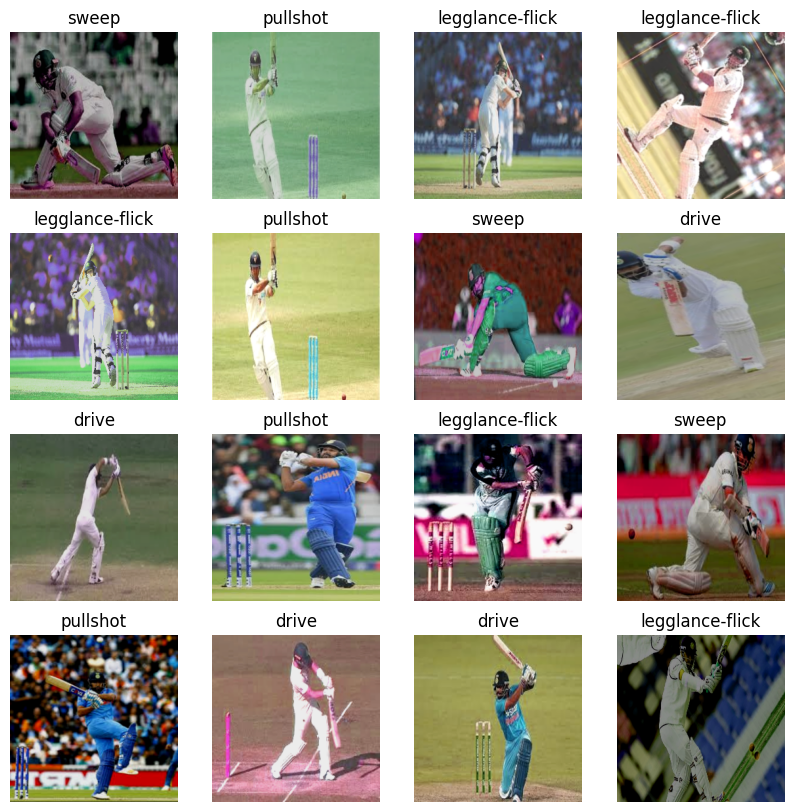

In [59]:
plt.figure(figsize=(10,10))
for images, labels in df.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### ***Splitting Dataset into Train/Dev/Test Set***

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [7]:
print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 118
Validation size: 14
Test size: 16


In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### ***Data Normalization***

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255)
])

### ***Training my Own CNN model***

In [10]:
model = models.Sequential([
    layers.Input(shape=(256,256,3)),
    resize_and_rescale,

    layers.Conv2D(16,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(4,activation="softmax")
])


In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,836 (2.77 MB)

 Trainable params: 724,836 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])

In [13]:
history=model.fit(train_ds,
                validation_data=val_ds,
                batch_size=32,
                epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.3704 - loss: 1.3174 - val_accuracy: 0.4866 - val_loss: 1.1849
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - accuracy: 0.5743 - loss: 1.0049 - val_accuracy: 0.6629 - val_loss: 0.8178
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.7574 - loss: 0.6297 - val_accuracy: 0.7879 - val_loss: 0.5401
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.8631 - loss: 0.3915 - val_accuracy: 0.8817 - val_loss: 0.3667
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 282ms/step - accuracy: 0.9107 - loss: 0.2630 - val_accuracy: 0.9174 - val_loss: 0.2613
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - accuracy: 0.9394 - loss: 0.1706 - val_accuracy: 0.9286 - val_loss: 0.2386
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step - accuracy: 0.9591 - loss: 0.1196 - val_accuracy: 0.9643 - val_loss: 0.1864
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.9814 - loss: 0

In [14]:
model.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9707 - loss: 0.1076


[0.10757232457399368, 0.970703125]

In [15]:
model.evaluate(val_ds.skip(0))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9688 - loss: 0.1923


[0.1923297494649887, 0.96875]

### ***Transfer Learning using ResNet50***

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
model_resnet = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")
])

In [17]:
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
model_resnet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [19]:
history=model_resnet.fit(train_ds,
                validation_data=val_ds,
                batch_size=32,
                epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.3037 - loss: 1.4273 - val_accuracy: 0.2701 - val_loss: 1.3509
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.3611 - loss: 1.3346 - val_accuracy: 0.3214 - val_loss: 1.3117
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.3723 - loss: 1.3110 - val_accuracy: 0.4286 - val_loss: 1.2690
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.3960 - loss: 1.2834 - val_accuracy: 0.4688 - val_loss: 1.2459
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.4063 - loss: 1.2751 - val_accuracy: 0.4799 - val_loss: 1.2331
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 528s 4s/step - accuracy: 0.4100 - loss: 1.2670 - val_accuracy: 0.4866 - val_loss: 1.2308
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.4340 - loss: 1.2410 - val_accuracy: 0.4844 - val_loss: 1.2170
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.4310 - loss: 1.2463 - val_accu

In [20]:
model_resnet.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4961 - loss: 1.1703


[1.1703165769577026, 0.49609375]

### ***Transfer Learning using MobilleNetV2***

In [21]:
base_model=MobileNetV2(input_shape=(256,256,3), include_top=False, weights="imagenet")
base_model.trainable=False
model_mobilenet = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(4, activation="softmax")
])

C:\Users\User\AppData\Local\Temp\ipykernel_6828\3969682835.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=MobileNetV2(input_shape=(256,256,3), include_top=False, weights="imagenet")


In [22]:
model_mobilenet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [23]:
model_mobilenet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history_mobilenet=model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 106s 849ms/step - accuracy: 0.7970 - loss: 0.5657 - val_accuracy: 0.9665 - val_loss: 0.1748
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 641ms/step - accuracy: 0.9580 - loss: 0.1612 - val_accuracy: 0.9777 - val_loss: 0.0969
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 74s 629ms/step - accuracy: 0.9785 - loss: 0.0908 - val_accuracy: 0.9933 - val_loss: 0.0527
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 642ms/step - accuracy: 0.9920 - loss: 0.0520 - val_accuracy: 0.9866 - val_loss: 0.0450
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 640ms/step - accuracy: 0.9973 - loss: 0.0299 - val_accuracy: 0.9933 - val_loss: 0.0357
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 635ms/step - accuracy: 0.9989 - loss: 0.0179 - val_accuracy: 0.9978 - val_loss: 0.0170
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 640ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.9978 - val_loss: 0.0178
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 612ms/step - accuracy: 1.0000 - loss: 

In [25]:
model_mobilenet.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 650ms/step - accuracy: 0.9941 - loss: 0.0129


[0.012914150953292847, 0.994140625]

#### ***The model appears to exhibit slight overfitting. To mitigate this, we will employ regularization techniques such as Dropout and Early Stopping. Data augmentation will not be applied, as the dataset provider has already performed it; introducing additional augmentation may negatively impact model performance.***

In [26]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256,256,3),  
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model_mobilenet = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Dense(4, activation="softmax")
])

C:\Users\User\AppData\Local\Temp\ipykernel_6828\3393206267.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [27]:
model_mobilenet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [29]:
model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[early_stop]
)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 86s 680ms/step - accuracy: 0.6939 - loss: 1.0055 - val_accuracy: 0.9330 - val_loss: 0.4841
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - accuracy: 0.8953 - loss: 0.5084 - val_accuracy: 0.9688 - val_loss: 0.3233
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - accuracy: 0.9405 - loss: 0.3649 - val_accuracy: 0.9888 - val_loss: 0.2568
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - accuracy: 0.9543 - loss: 0.3165 - val_accuracy: 0.9821 - val_loss: 0.2361
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 614ms/step - accuracy: 0.9694 - loss: 0.2609 - val_accuracy: 0.9911 - val_loss: 0.1958
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 624ms/step - accuracy: 0.9734 - loss: 0.2306 - val_accuracy: 0.9933 - val_loss: 0.1734
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 73s 621ms/step - accuracy: 0.9710 - loss: 0.2232 - val_accuracy: 0.9955 - val_loss: 0.1622
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 776ms/step - accuracy: 0.9822 - loss: 0

In [30]:
model_mobilenet.evaluate(test_ds.skip(0))

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 881ms/step - accuracy: 0.9961 - loss: 0.1385


[0.1385466754436493, 0.99609375]

In [31]:
model_mobilenet.evaluate(val_ds.skip(0))

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.9978 - loss: 0.1343


[0.13430838286876678, 0.9977678656578064]

In [39]:
print(history.params)
print(history_mobilenet.history.keys())

{'verbose': 'auto', 'epochs': 10, 'steps': 118}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### ***Plotting Model History***

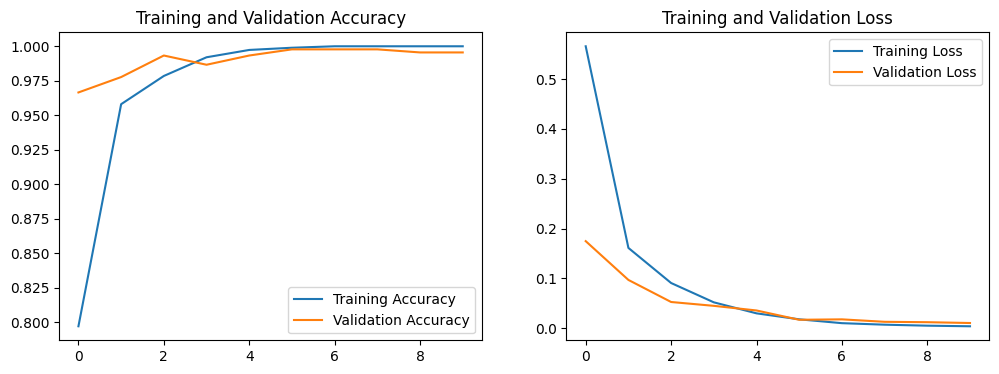

In [42]:
acc = history_mobilenet.history["accuracy"]
val_acc = history_mobilenet.history["val_accuracy"]
loss = history_mobilenet.history["loss"]
val_loss = history_mobilenet.history["val_loss"]
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


### ***Checking First Imaage***

First Image To Predict
Actual Label: legglance-flick
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label is: legglance-flick


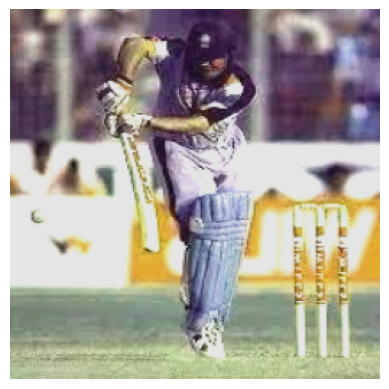

In [43]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0]
    print("First Image To Predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual Label:",class_names[first_label])
    batch_prediction=model_mobilenet.predict(images_batch)
    print("Predicted Label is:",class_names[np.argmax(batch_prediction[0])])

### ***Prediction function***

In [34]:
def predict(model_mobilenet,img):
    img_array=tf.expand_dims(img,0)
    predictions=model_mobilenet.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

### ***Making Prediction on Images with Confidence Score and Actual Label***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


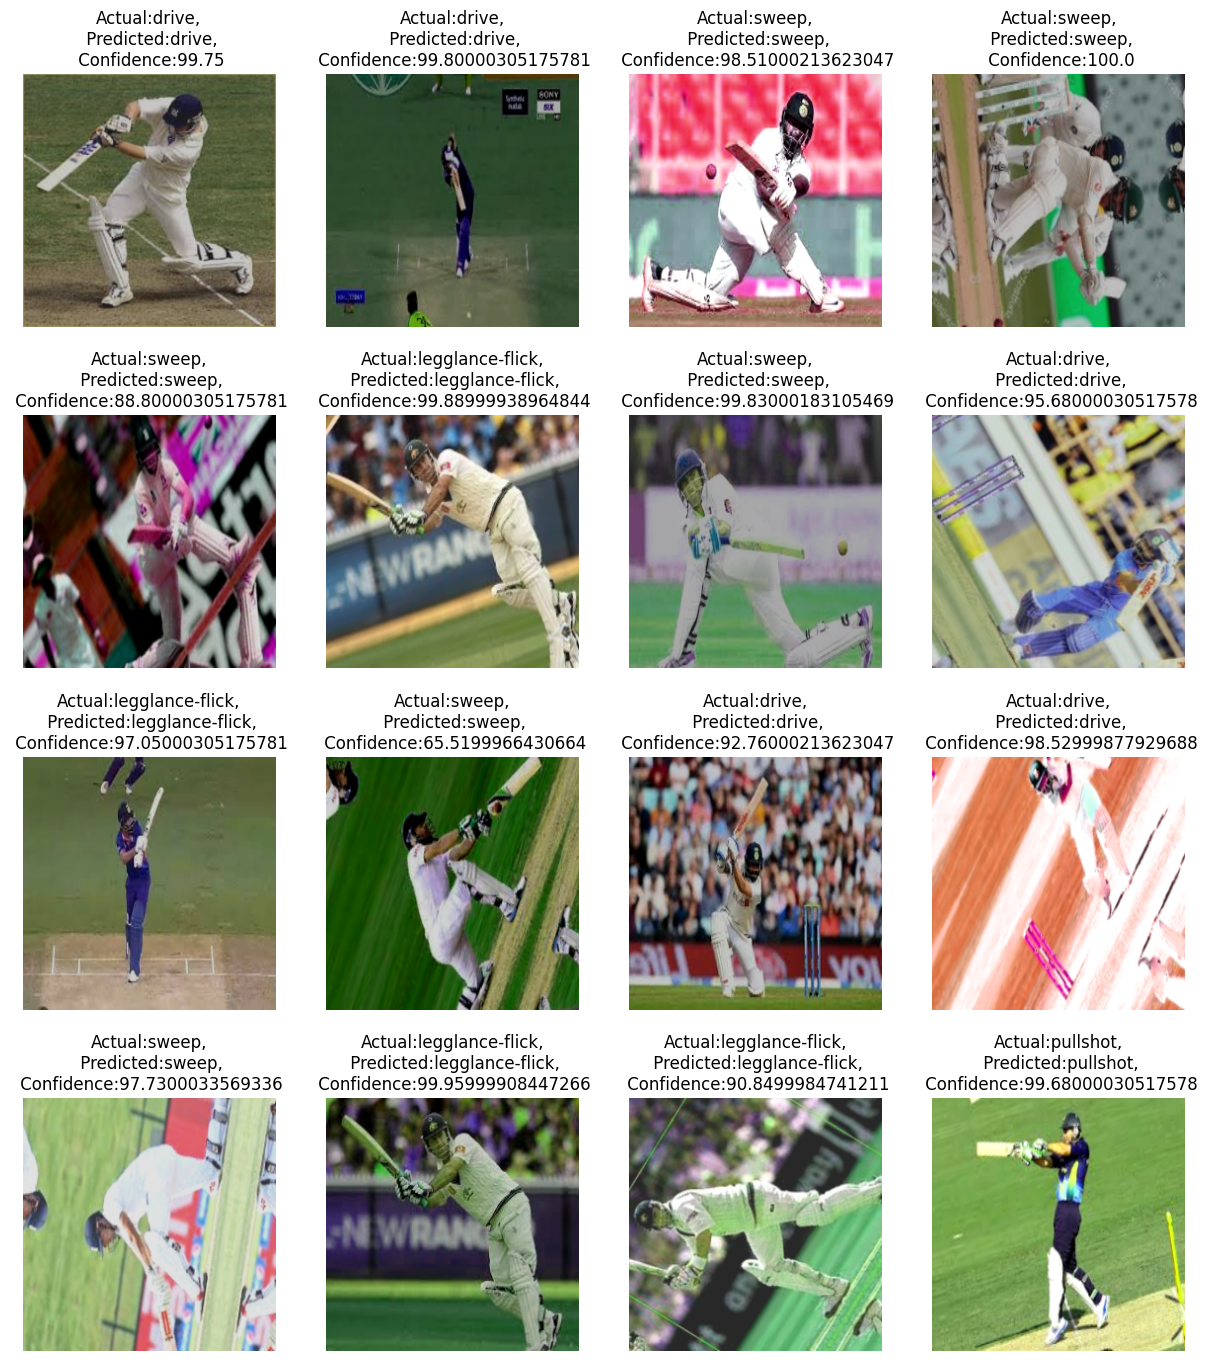

In [44]:
plt.figure(figsize=(15,17))
for images,labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model_mobilenet,images[i].numpy().astype("uint8"))
        actual_class=class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")

        plt.axis("off")

### ***Saving All Models***

In [36]:
model.save("custom.keras")
model_mobilenet.save("mobilenetv2.keras")
model_resnet.save("resnet50.keras")